# Data Generation - Variational Auto Encoder (VAE)

In [1]:
import os
import math
from tqdm.auto import tqdm

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
from utils.data import Data
from utils.hardware import Hardware
from utils.model_utils import ModelUtils

/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/Users/francois.soulier/miniconda/envs/SCIA/lib/python3.10/site-packages/jinja2/environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


In [3]:
base_dir: str = os.path.join(os.getcwd(), 'data')

tuple_data: tuple[list[pd.DataFrame], np.ndarray, np.ndarray] = Data.load_data(base_dir)

# Unpack data
pd_data: list[pd.DataFrame] = tuple_data[0]
labels: np.ndarray = tuple_data[1]
classes: np.ndarray = tuple_data[2]

0 OUI
1 NON
2 VRAI
3 FAUX


In [4]:
data: np.ndarray = Data.convert_to_numpy(pd_data)

## Data Generation

### Encoder

In [5]:
class Encoder(nn.Module):
    """
    Class defining the encoder architecture of the Variational Autoencoder.
    """
    def __init__(self, hidden_dim: int = 2):
        super(Encoder, self).__init__()
        self.conv1 = nn.Conv2d(1, hidden_dim, kernel_size=3, stride=2, padding=1)
        self.conv2 = nn.Conv2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1)
        self.conv3 = nn.Conv2d(hidden_dim, hidden_dim * 2, kernel_size=3, stride=2, padding=1)
        self.conv4 = nn.Conv2d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, stride=2, padding=1)

        # Activation functions
        self.relu = nn.LeakyReLU(0.1)

        # Dropout layer(s)
        self.dropout = nn.Dropout(p=0.3)
        
        # Pooling layer
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the model. This method is called when performing inference, training or evaluation.
        Params:
            x (torch.Tensor): Input data
        Returns:
            torch.Tensor: Output data.
                          The shape of the output tensor depends on the number of classes that characterizes the model.
        """
        x = self.relu(self.conv1(x))
        x = self.relu(self.conv2(x))
        x = self.relu(self.conv3(x))
        encoded = self.relu(self.conv4(x))

        encoded = self.dropout(encoded)
        return encoded

### Decoder

In [6]:
class Trim(nn.Module):
    """
    Class that defines a trimming layer.
    """
    def __init__(self, size1: int, size2: int):
        super(Trim, self).__init__()
        self.size1 = size1
        self.size2 = size2
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the layer. This method is called when performing inference, training or evaluation.
        Params:
            x (torch.Tensor): Input data
        Returns:
            torch.Tensor: Trimmed data.
        """
        return x[:, :, :self.size1, :self.size2]

In [7]:
class Decoder(nn.Module):
    """
    Class defining the decoder architecture of the VAE.
    """
    def __init__(self, hidden_dim: int = 2, img_shape: tuple[int, int] = (72, 114)):
        super(Decoder, self).__init__()

        self.deconv1 = nn.ConvTranspose2d(hidden_dim * 2, hidden_dim * 2, kernel_size=3, stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(hidden_dim * 2, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.deconv3 = nn.ConvTranspose2d(hidden_dim, hidden_dim, kernel_size=3, stride=2, padding=1, output_padding=0)
        self.deconv4 = nn.ConvTranspose2d(hidden_dim, 1, kernel_size=3, stride=2, padding=1, output_padding=0)

        # Activation functions
        self.relu = nn.LeakyReLU(0.1)

        # Trimming
        self.trim = Trim(img_shape[0], img_shape[1])

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass of the decoder.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Decoded tensor representing the reconstructed data.
        """
        x = self.relu(self.deconv1(x))
        x = self.relu(self.deconv2(x))
        x = self.relu(self.deconv3(x))
        decoded = self.relu(self.deconv4(x))

        decoded = self.trim(decoded)
        
        return decoded

### Class Conditional Variational Autoencoder (CCVAE)

<u>**Log-variance:**</u><br><br>
Instead of learning the variance $\sigma^2$, we here learn the log-variance $\log(\sigma^2)$ because it can take any real number, while the variance can only take positive values. We can then exponentiate the log-variance to get the variance. Here is how we can do this:<br>

$$\log(\sigma^2) = 2 * \log(\sigma)$$
$$\log(\sigma^2) / 2 = \log(\sigma)$$
$$e^{\log(\sigma^2) / 2} = \sigma$$

In [8]:
DEVICE = Hardware.device()

class CCVAE(nn.Module):
    """
    Variational AutoEncoder class.
    """
    def __init__(self, hidden_dim: int = 128, latent_dim: int = 2, input_shape: tuple = (72, 114), nb_classes: int = 4):
        super(CCVAE, self).__init__()
        self.encoder = Encoder(hidden_dim=hidden_dim)
        self.decoder = Decoder(hidden_dim=hidden_dim)

        self.nb_features = hidden_dim * 2
        self.intermediate_shape = (math.ceil(input_shape[0] / (2 ** 4)), math.ceil(input_shape[1] / (2 ** 4)))

        intermediary_dim = self.nb_features * self.intermediate_shape[0] * self.intermediate_shape[1]

        # Fully connected layers
        self.fc1 = nn.Linear(intermediary_dim + nb_classes, hidden_dim)
        self.mu_layer = nn.Linear(hidden_dim, latent_dim)
        self.logvar_layer = nn.Linear(hidden_dim, latent_dim)
        self.fc2 = nn.Linear(latent_dim + nb_classes, intermediary_dim)

        self.latent_dim = latent_dim
        self.nb_classes = nb_classes

    def reparametrize(self, mu, logvar):
        sigma = torch.exp(logvar * 0.5).to(DEVICE)
        epsilon = torch.randn_like(sigma).to(DEVICE)

        return mu + epsilon * sigma
    
    def encode(self, x, y):
        encoded = self.encoder(x)
        flattened_encoded = encoded.view(x.size(0), -1)
        
        flattened_encoded = torch.cat((flattened_encoded, y), dim=1)
        hidden = self.fc1(flattened_encoded)

        return hidden
    
    def decode(self, z, y):
        z = torch.cat((z, y), dim=1)
        z = self.fc2(z)

        reshaped_z = z.view(z.size(0),
                            self.nb_features,
                            self.intermediate_shape[0],
                            self.intermediate_shape[1])

        return self.decoder(reshaped_z)
    
    def forward(self, x, y):
        y_encoded = F.one_hot(y, num_classes=self.nb_classes).float().to(DEVICE)
        encoded = self.encode(x, y_encoded)

        mu, logvar = self.mu_layer(encoded), self.logvar_layer(encoded)

        z = self.reparametrize(mu, logvar)

        decoded = self.decode(z, y_encoded)

        return decoded, mu, logvar

    def loss_function(self, x, x_hat, mu, logvar):
        reconstruction_loss = nn.MSELoss()(x_hat, x)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

        return reconstruction_loss + kld_loss
    
    def sample(self, n):
        with torch.no_grad():
            y = torch.randint(0, 4, (n, 1)).to(DEVICE)
            y_encoded = F.one_hot(y, num_classes=4).float().squeeze(1)
            z = torch.randn(n, self.latent_dim).to(DEVICE)
            decoded = self.decode(z, y_encoded)
        return decoded.cpu().detach().numpy(), y.squeeze(-1).cpu().detach().numpy()
    
    def fit(self, X_train, X_val, y_train, y_val ,epochs: int = 10, learning_rate: float = 1e-3, batch_size: int = 32):
        optimizer = torch.optim.Adam(self.parameters(), lr=learning_rate)

        n_train_batches = X_train.shape[0] // batch_size
        n_val_batches = X_val.shape[0] // batch_size

        history = pd.DataFrame(columns=['loss', 'val_loss'])

        print('Training on {} batches, validating on {} batches'.format(n_train_batches, n_val_batches))

        for epoch in tqdm(range(epochs)):
            mean_loss = 0
            self.train()
            for x, y in Data.labeled_data_generator(X_train, y_train, batch_size=batch_size):
                x = x.to(DEVICE).unsqueeze(1)
                y = y.to(DEVICE)
                x_hat, mu, logvar = self(x, y)
                loss = self.loss_function(x, x_hat, mu, logvar)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                mean_loss += loss.item()
            
            mean_loss /= n_train_batches

            self.eval()
            with torch.no_grad():
                mean_val_loss = 0
                for x, y in Data.labeled_data_generator(X_val, y_val, batch_size=batch_size):
                    x = x.to(DEVICE).unsqueeze(1)
                    y = y.to(DEVICE)
                    x_hat, mu, logvar = self(x, y)
                    val_loss = self.loss_function(x, x_hat, mu, logvar)

                    mean_val_loss += val_loss.item()

                mean_val_loss /= n_val_batches
                print('epoch [{}/{}] loss: {:.2f} | validation Loss: {:.2f}                         '.format(epoch+1, epochs, mean_loss, mean_val_loss), end='\r')

            history.loc[epoch] = [mean_loss, mean_val_loss]
        
        self.history = history

    def evaluate(self, X_test, y_test, batch_size: int = 32):
        self.eval()
        with torch.no_grad():
            test_mean_loss = 0
            n_test_batches = X_test.shape[0] // batch_size
            for x, y in Data.labeled_data_generator(X_test, y_test, batch_size=batch_size):
                x = x.to(DEVICE).unsqueeze(1)
                y = y.to(DEVICE)
                x_hat, z_mu, z_logvar = self(x, y)
                test_mean_loss = self.loss_function(x_hat, x, z_mu, z_logvar)
                test_mean_loss += test_mean_loss.item()
        
        test_mean_loss = test_mean_loss / n_test_batches
        print(f"Test loss: {test_mean_loss:.4f}")
    
    def plot_history(self):
        plt.plot(self.history['loss'], label='loss')
        plt.plot(self.history['val_loss'], label='val_loss')
        plt.legend(['Loss', 'Validation Loss'])
        plt.ylabel('Loss')
        plt.xlabel('Epoch')
        plt.show()

### Training

In [9]:
seed: int = 42
torch.manual_seed(seed)
torch.mps.manual_seed(seed)

X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=seed)

ccvae = CCVAE(hidden_dim=32, latent_dim=32).to(DEVICE)
ccvae.fit(X_train, X_val, y_train, y_val, epochs=1500, learning_rate=1e-3, batch_size=4)

Training on 17 batches, validating on 3 batches


  0%|          | 0/1500 [00:00<?, ?it/s]

#### History - Training & Validation Loss

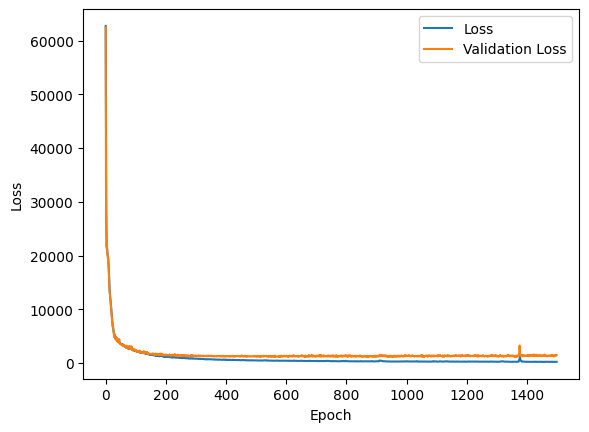

In [10]:
ccvae.plot_history()

### Evaluation - CCVAE

In [11]:
ccvae.evaluate(X_test, y_test, batch_size=4)

Test loss: 435.9521


### Generation of new samples

In [26]:
n_samples = 5000
generation_seed = 90

torch.manual_seed(generation_seed)
X_gen, y_gen = ccvae.sample(n=n_samples)

# Run inference on previously trained classification model
classified_output = ModelUtils.run_pytorch_inference(path="models/vr_gesture_recognizer.onnx", inputs=X_gen)

accuracy = accuracy_score(y_gen, classified_output)
print(f"Generation accuracy: {accuracy * 100:.2f}%")

Generation accuracy: 100.00%


## Classification

### Model

  0%|          | 0/20 [00:00<?, ?it/s]

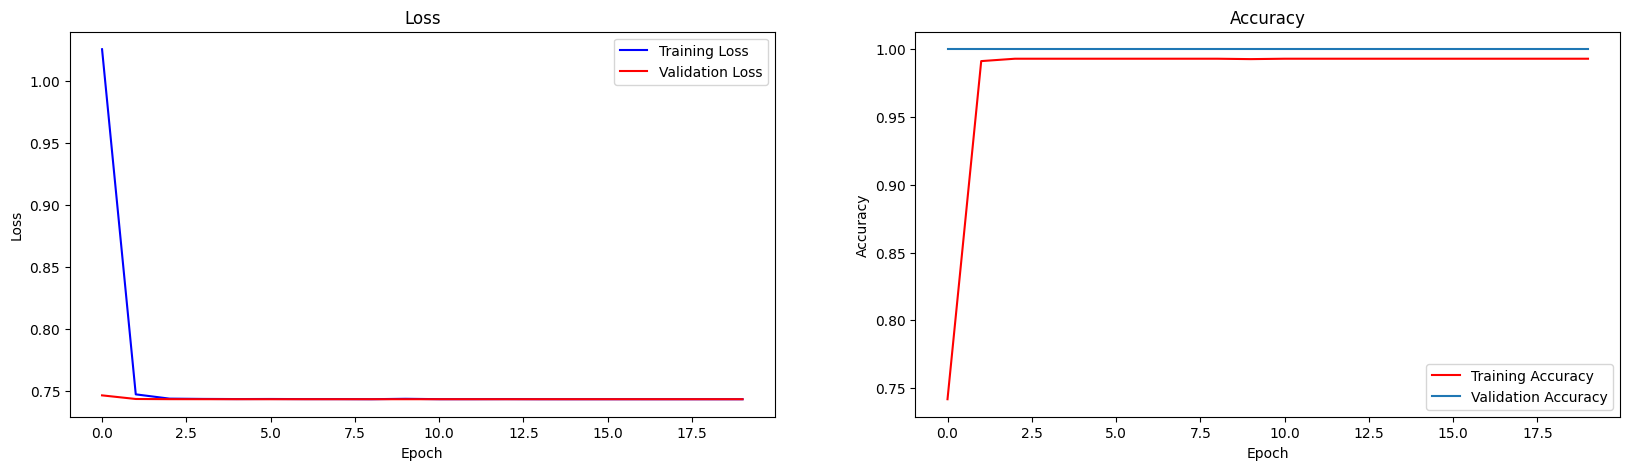

In [27]:
from utils.vr_gesture_recognizer import VRGestureRecognizer
from utils.hardware import Hardware

DEVICE = Hardware.device()
BATCH_SIZE = 32
EPOCHS = 20
LEARNING_RATE = 1e-4
HIDDEN_SIZE = 128
NUM_LABELS = classes.shape[0]

# Loss function
loss_fn = nn.CrossEntropyLoss()

gesture_recognizer = VRGestureRecognizer(hidden_size=HIDDEN_SIZE, num_classes=NUM_LABELS).to(DEVICE)

X_train, X_test, y_train, y_test = train_test_split(X_gen.squeeze(1), y_gen, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state=42)

gesture_recognizer.compile(loss_fn=loss_fn)
training_history = gesture_recognizer.fit(X_train, y_train, X_val, y_val, epochs=EPOCHS, batch_size=BATCH_SIZE, learning_rate=LEARNING_RATE)

gesture_recognizer.plot_history()

### Evaluation on real data

In [28]:
# Test on real data
test_loss, test_accuracy = gesture_recognizer.to(Hardware.device()).evaluate(data, labels)
print(f"Loss: {test_loss.item():.2f} | Accuracy: {test_accuracy * 100:.2f}%")

Loss: 0.74 | Accuracy: 100.00%
